In [3]:
import re

import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import BertModel, BertTokenizer

sns.set_theme()

In [4]:
df = pd.read_csv("../data/data_final.csv")
df = df.dropna(subset=["grade", "cv", "job_desc"])

In [5]:
df["grade"] = df["grade"].clip(lower=1, upper=5)
df["grade"] = df["grade"].replace(2.5, 2.0)

df.grade.value_counts()

grade
3.5    287
4.0    184
3.0    166
2.0     38
4.5     26
5.0     14
1.0     10
Name: count, dtype: int64

In [6]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["grade"])

train, test = train.reset_index(), test.reset_index()

print(f"Размер тренировочной выборки: {train.shape}")
print(f"Размер тестовой выборки: {test.shape}")

Размер тренировочной выборки: (580, 19)
Размер тестовой выборки: (145, 19)


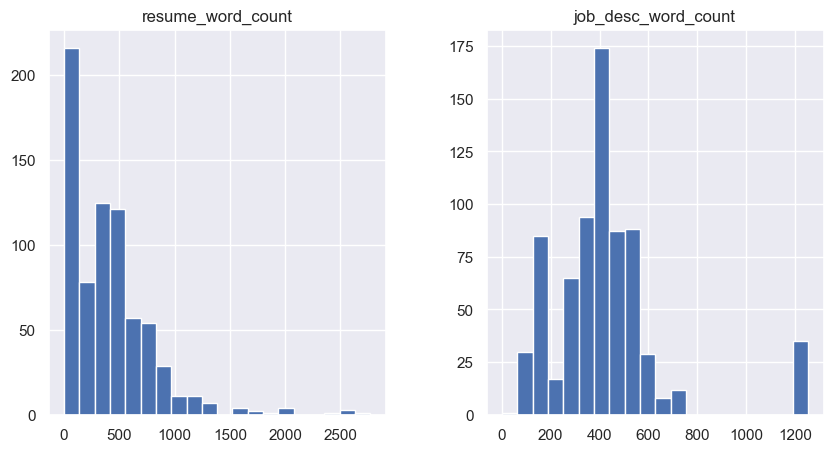

In [7]:
df["resume_word_count"] = df["cv"].apply(lambda x: len(str(x).split()))
df["job_desc_word_count"] = df["job_desc"].apply(lambda x: len(str(x).split()))

df[["resume_word_count", "job_desc_word_count"]].hist(bins=20, figsize=(10, 5));

In [8]:
print(df["resume_word_count"].max(), df["job_desc_word_count"].max())

2771 1254


In [10]:
class SeparateTextDataset(Dataset):
    def __init__(self, data, tokenizer, transform=None):
        self.cv_texts = data["cv"]
        self.jd_texts = data["job_desc"]
        self.grades = data["grade"]
        self.tokenizer = tokenizer

        # по-хорошему добавить предобработку
        # как минимум в виде чистки регулярками
        self.transform = transform

    def __len__(self):
        return len(self.grades)

    def __getitem__(self, idx):
        cv_encoded = self.tokenizer(
            self.cv_texts[idx],
            max_length=512,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        jd_encoded = self.tokenizer(
            self.jd_texts[idx],
            max_length=512,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        cv_input_ids = cv_encoded["input_ids"].squeeze(0)
        cv_attention_mask = cv_encoded["attention_mask"].squeeze(0)

        jd_input_ids = jd_encoded["input_ids"].squeeze(0)
        jd_attention_mask = jd_encoded["attention_mask"].squeeze(0)

        grade = torch.tensor(self.grades[idx], dtype=torch.float)

        return cv_input_ids, cv_attention_mask, jd_input_ids, jd_attention_mask, grade

In [11]:
class BERTSeparateEmbeddings(nn.Module):
    def __init__(
        self,
        pretrained_model_name="bert-base-uncased",
        froze_bert=True,
        num_labels=1,
        dropout=0.1,
    ):
        super(BERTSeparateEmbeddings, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)

        if froze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        hidden_size = self.bert.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_labels),
        )

    def forward(self, cv_input_ids, cv_attention_mask, jd_input_ids, jd_attention_mask):
        # Получаем эмбеддинги для CV
        cv_outputs = self.bert(input_ids=cv_input_ids, attention_mask=cv_attention_mask)
        cv_cls_output = cv_outputs.pooler_output  # [CLS] токен для CV

        # Получаем эмбеддинги для Job Description
        jd_outputs = self.bert(input_ids=jd_input_ids, attention_mask=jd_attention_mask)
        jd_cls_output = jd_outputs.pooler_output  # [CLS] токен для Job Description

        combined_output = torch.cat((cv_cls_output, jd_cls_output), dim=1)

        logits = self.classifier(combined_output)
        return logits

In [12]:
HF_MODEL_NAME = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(HF_MODEL_NAME)

train_dataset = SeparateTextDataset(train, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = SeparateTextDataset(test, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = BERTSeparateEmbeddings(
    pretrained_model_name=HF_MODEL_NAME,
    num_labels=1,
).to(device)

cuda


In [14]:
EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 2e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

criterion = nn.MSELoss()

for epoch in tqdm(range(EPOCHS)):
    model.train()
    total_loss = 0
    for batch in train_loader:
        cv_input_ids, cv_attention_mask, jd_input_ids, jd_attention_mask, labels = [
            b.to(device) for b in batch
        ]

        optimizer.zero_grad()
        logits = model(
            cv_input_ids, cv_attention_mask, jd_input_ids, jd_attention_mask
        ).squeeze(-1)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

 20%|██        | 1/5 [00:28<01:55, 28.82s/it]

Epoch 1, Loss: 6.725237343762372


 40%|████      | 2/5 [01:01<01:32, 30.84s/it]

Epoch 2, Loss: 1.2042538620330192


 60%|██████    | 3/5 [01:31<01:01, 30.68s/it]

Epoch 3, Loss: 0.5793579700025352


 80%|████████  | 4/5 [02:02<00:30, 30.64s/it]

Epoch 4, Loss: 0.5586438283726975


100%|██████████| 5/5 [02:32<00:00, 30.56s/it]

Epoch 5, Loss: 0.5420744455343968


In [15]:
def print_metrics(model, test_loader):
    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            cv_input_ids, cv_attention_mask, jd_input_ids, jd_attention_mask, labels = [
                b.to(device) for b in batch
            ]

            predictions = model(
                cv_input_ids, cv_attention_mask, jd_input_ids, jd_attention_mask
            ).squeeze(-1)

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    mae = mean_absolute_error(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)

    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")

In [16]:
print_metrics(model, test_loader)

MAE: 0.5411
MSE: 0.5689


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BERTSeparateEmbeddings(
    pretrained_model_name=HF_MODEL_NAME, num_labels=1, froze_bert=False
).to(device)

EPOCHS = 5
BATCH_SIZE = 16
LEARNING_RATE = 2e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

criterion = nn.MSELoss()

for epoch in tqdm(range(EPOCHS)):
    model.train()
    total_loss = 0
    for batch in train_loader:
        cv_input_ids, cv_attention_mask, jd_input_ids, jd_attention_mask, labels = [
            b.to(device) for b in batch
        ]

        optimizer.zero_grad()
        logits = model(
            cv_input_ids, cv_attention_mask, jd_input_ids, jd_attention_mask
        ).squeeze(-1)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

 20%|██        | 1/5 [13:20<53:22, 800.75s/it]

Epoch 1, Loss: 3.148404193891061


 40%|████      | 2/5 [26:44<40:07, 802.38s/it]

Epoch 2, Loss: 0.43443206214421504


 60%|██████    | 3/5 [39:04<25:47, 773.95s/it]

Epoch 3, Loss: 0.4218942474674534


 80%|████████  | 4/5 [51:26<12:41, 761.41s/it]

Epoch 4, Loss: 0.41048130876309163


100%|██████████| 5/5 [1:02:02<00:00, 744.46s/it]

Epoch 5, Loss: 0.3883714000316891


In [16]:
print_metrics(model, test_loader)

MAE: 0.4525
MSE: 0.4310
